# DATA EXPLORATION

In this notebook I will explore and see how the data is built. My goal is try to undestand the evolution of the data I'm working with, and make some hypothessis about what should I do next.

### Imports

In [ ]:
# Data Manipulation and Analysis
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns

# Machine Learning Models
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neural_network import MLPRegressor

# Metrics and Evaluation
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, explained_variance_score, r2_score,
    mean_poisson_deviance, mean_gamma_deviance, accuracy_score
)

# Time Series Analysis
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose


# File Handling
import os

# Math
import math

# Time series models
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Statistics
from scipy.stats import f_oneway

### Dataset Class

The idea if this class is to group every function I need to work with the dataset. This way I would have everything I need in the same place.

In [72]:
class Dataset(object):
    def __init__(self, dataset, name):
        if not isinstance(dataset, pd.DataFrame):
            raise ValueError("Input 'dataset' must be a pandas DataFrame.")
        
        self.dataset = dataset.copy()

        self.name = name
        
        self.dataset['time'] = pd.to_datetime(self.dataset['time'])
        self.dataset.set_index('time', inplace=True)
        
        training_size = int(len(self.dataset) * 0.7)
        self.train = self.dataset.iloc[:training_size]
        self.test = self.dataset.iloc[training_size:]
        
        
    def __str__(self):
        return self.name
    
    def show_dataset(self, head=False, tail=False):       
        if head:
            return self.dataset.head(head)
        
        elif tail:
            return self.dataset.tail(tail)
        
        else:
            return self.dataset
    
    def reset_train_test(self, train_ratio=0.7):
        if 0 < train_ratio < 1:
            training_size = int(len(self.dataset) * train_ratio)

            self.train = self.dataset.iloc[:training_size]
            self.test = self.dataset.iloc[training_size:]

            print("Train ratio: {}".format(train_ratio))
            print("Test ratio: {}".format(1-train_ratio))
        
        else:
            print("Please, train ratio between 0 and 1")
            
    def split_data(self, feature_columns, target_column):
        X_train = self.train[feature_columns]
        Y_train = self.train[target_column]

        X_test = self.test[feature_columns]
        Y_test = self.test[target_column]

        return X_train, Y_train, X_test, Y_test
    
    def plot_candle(self):
        mpf.plot(self.dataset, type='line', volume=True, style='yahoo', figsize=(10,6))
    
    def plot_heatmap(self):    
        plt.figure(figsize=(10,5))

        correlation = self.dataset.corr()
        sns.heatmap(correlation, annot=True)

        plt.show()
        
    def show_nulls(self):
        return self.dataset.isna().sum()
    
    def check_time_gaps(self):
        return (self.dataset.index[1:]-self.dataset.index[:-1]).value_counts().head()

    def dicker_fuller(self, column):
        print ('Dickey-Fuller Test indicates:')
        df_test = adfuller(self.dataset[column], regression='ct', autolag='AIC')
        output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
        print(output)

    def print_granularity(self, unit='seconds'):
        units = {'seconds': 1, 'minutes': 1/60, 'hours': 1/3600}
        
        interval = self.granularity * units[unit]
        
        print('Intervals of {} {}'.format(interval, unit))

### Download the data

Here I download the data. Each of the different datasets contains the data about BitCoin. The difference between then is the granularity. I should study which of them is the best option to make the predictions.

In [ ]:
path = os.path.abspath('Datasets/')

NETFLIX = pd.read_csv(os.path.join(path, 'NETFLIX/NFLX.csv'), 'Netflix')

### Analysing data and Time Gaps

I have to check if there are any time gaps. For this, I'm going to use the `check_time_gaps()` function that BTC class already has. Missing asset data, for a given minute, is not represented by NaN's, but instead by the absence of those rows. I can check the timestamp difference between consecutive rows to see if there is missing data.

In [74]:
BTC_60.check_time_gaps()

time
0 days 00:01:00    702003
0 days 00:02:00     68069
0 days 00:03:00     13542
0 days 00:04:00      3740
0 days 00:05:00      1310
Name: count, dtype: int64

In [75]:
BTC_300.check_time_gaps()

time
0 days 00:05:00    180329
0 days 00:10:00       432
0 days 00:15:00        10
0 days 04:50:00         1
0 days 00:20:00         1
Name: count, dtype: int64

In [76]:
BTC_900.check_time_gaps()

time
0 days 00:15:00    60407
0 days 04:45:00        1
0 days 00:30:00        1
0 days 00:45:00        1
Name: count, dtype: int64

In [77]:
BTC_3600.check_time_gaps()

time
0 days 01:00:00    15102
0 days 05:00:00        1
Name: count, dtype: int64

In [78]:
BTC_21600.check_time_gaps()

time
0 days 06:00:00    2517
Name: count, dtype: int64

In [79]:
BTC_86400.check_time_gaps()

time
1 days    628
Name: count, dtype: int64

Notice that there are many gaps in the data. To work with most time series models, I should preprocess our data into a format without time gaps. The datasets I would not use are BTC_900 and BTC_3600, due to the different time gaps

Now let's look for NaN values, if there're any. Excluding the BTC_900 and BTC_3600 datasets

In [80]:
BTC_60.dataset.isna().sum()

low       0
high      0
open      0
close     0
volume    0
dtype: int64

In [81]:
BTC_300.dataset.isna().sum()

low       0
high      0
open      0
close     0
volume    0
dtype: int64

In [82]:
BTC_21600.dataset.isna().sum()

low       0
high      0
open      0
close     0
volume    0
dtype: int64

In [83]:
BTC_86400.dataset.isna().sum()

low       0
high      0
open      0
close     0
volume    0
dtype: int64

There are no NaN values from this datasets.

The best dataset is the one with intervals of 900 seconds (51 minutes). This is because the intervals are not as little as the 60 one, which makes the dataset smaller, but still we have tons of data we can work with. The other datasets don't have as much data, so, for the moment, will be set apart.

### PLOTTING THE DATASET

For further investigations, let's have a look at how the data is displayed

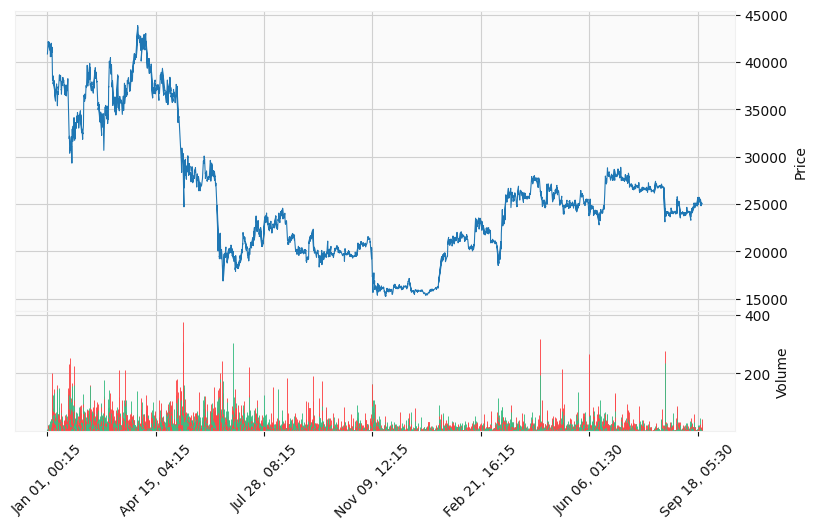

In [91]:
BTC_900.plot_candle()

### Studying the correlation

Let's have a look at the correlation using the `plot_heatmap()` function that the class `BTC` already has

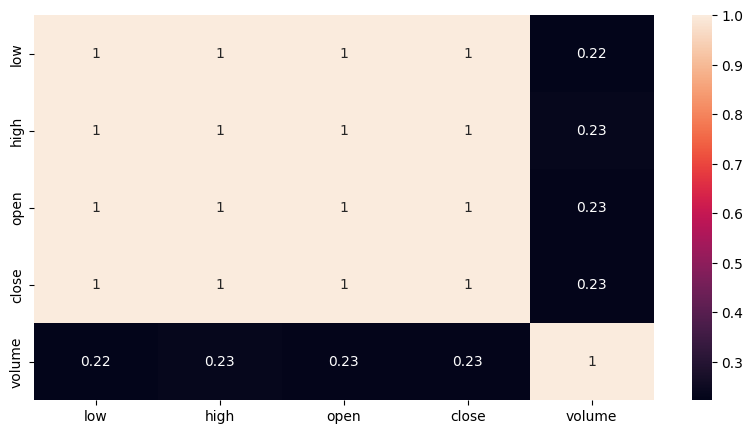

In [90]:
BTC_900.plot_heatmap()

The correlations are too high, let's make a scatter plot of the data to see what's happening.

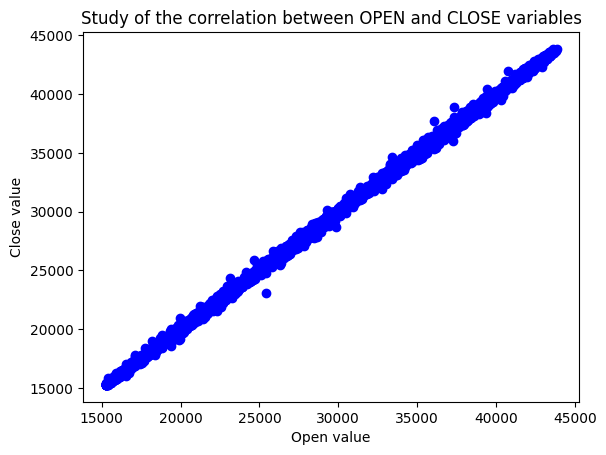

In [89]:
plt.figure()
plt.scatter(x=BTC_900.dataset['open'], y=BTC_900.dataset['close'], color='blue')
plt.title('Study of the correlation between OPEN and CLOSE variables')
plt.xlabel('Open value')
plt.ylabel('Close value')
plt.show()

Due to the tons of data we have, and the small change through consecutive intervals, we can see that the correlation is 1. This is going to be a problem, because predictions now are going to look ok, but in reality they are not going to be. I should be carefull chosing the model from this point, because is going to be too easy for it to get overfitted.